In [247]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


In [248]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [249]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [250]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [251]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [252]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

cp_cout_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    cp_cout_df.loc[item, 'count'] = count

cp_cout_df = cp_cout_df.reset_index()
cp_cout_df.columns = ['checkpoint', 'count'] 

In [253]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
2,ATEZOLIZUMAB,PD-L1,5x8l,S,N,D
3,M6903,TIM3,6txz,I,M,B
4,IPILIMUMAB,CTLA-4,6rp8,H,L,C
5,CEMIPLIMAB,PD-1,7wvm,A,B,E
6,PEMBROLIZUMAB,PD-1,5ggs,C,D,Y
8,AVELUMAB,PD-L1,5grj,H,L,A
9,TISLELIZUMAB,PD-1,7bxa,H,L,P
11,PEMBROLIZUMAB,PD-1,5jxe,D,C,B
12,IPILIMUMAB,CTLA-4,6rp8,h,l,c
14,ATEZOLIZUMAB,PD-L1,5xxy,H,L,A


In [254]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

with open('pdb_list.txt', 'w') as f:
    for pdb in pdb_list:
        f.write(pdb + '\n')

In [255]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['5x8l', 'S', 'N', 'D'],
 ['6txz', 'I', 'M', 'B'],
 ['6rp8', 'H', 'L', 'C'],
 ['7wvm', 'A', 'B', 'E'],
 ['5ggs', 'C', 'D', 'Y'],
 ['5grj', 'H', 'L', 'A'],
 ['7bxa', 'H', 'L', 'P'],
 ['5jxe', 'D', 'C', 'B'],
 ['6rp8', 'h', 'l', 'c'],
 ['5xxy', 'H', 'L', 'A'],
 ['8gy5', 'A', 'B', 'Q'],
 ['6k0y', 'A', 'B', 'C'],
 ['5jxe', 'G', 'F', 'A'],
 ['7bxa', 'B', 'C', 'A'],
 ['5x8l', 'H', 'M', 'C'],
 ['6xkr', 'H', 'L', 'P'],
 ['5x8m', 'B', 'C', 'A'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5x8l', 'F', 'K', 'A'],
 ['5tru', 'H', 'L', 'C'],
 ['7cu5', 'A', 'A', 'Q'],
 ['9dq3', 'H', 'L', 'C'],
 ['5xj4', 'H', 'L', 'A'],
 ['7cgw', 'A', 'B', 'C'],
 ['6txz', 'K', 'O', 'D'],
 ['7wvm', 'C', 'D', 'F'],
 ['9dq4', 'H', 'L', 'A'],
 ['5b8c', 'B', 'A', 'C'],
 ['5tru', 'h', 'l', 'c'],
 ['5xj3', 'A', 'B', 'C'],
 ['8gy5', 'H', 'L', 'P'],
 ['7su1', 'H', 'L', 'C'],
 ['5b8c', 'K', 'J', 'L'],
 ['5wt9', 'H', 'L', 'G'],
 ['7cgw', 'H', 'L', 'P'],
 ['7su0', 'I', 'M', 'D'],
 ['6txz', 'J', 'N', 'C'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5x8l', 'G

# Paratope, Hydrogen-Bonds, Saltbridges

In [256]:
results = []

# input 
root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Your extracted list from your DataFrame Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain (e.g., salmon)
        cmd.color("salmon", "antigen")

        # Optional: highlight paratope (already near antigen)
        cmd.color("yellow", "paratope")

        # Surface area
        paratope_area = cmd.get_area("paratope")
        print(f"   ➤ Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # 1) antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # 2) antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session (optional) 
        session_out = os.path.join(dirpath, f"{pdb_id}paratope.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            "paratope_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df_struc_info = pd.DataFrame(results)
# Remove duplicate block
# Save results to CSV 
df_struc_info = pd.DataFrame(results)
df_struc_info.to_csv("paratope_surface_hbonds_salt_bridges_summary.csv", index=False)

print("All done. Results saved to 'paratope_surface_hbonds_salt_bridges_summary.csv'")

Processing 5x8l...
   ➤ Epitope surface area: 1629.12 Å²
Found 24 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 6txz...
   ➤ Epitope surface area: 1610.27 Å²
Found 24 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 6rp8...
   ➤ Epitope surface area: 1255.46 Å²
Found 20 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7wvm...
   ➤ Epitope surface area: 1319.53 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5ggs...
   ➤ Epitope surface area: 2143.82 Å²
Found 31 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 5grj...
   ➤ Epitope surface area: 1456.68 Å²
Found 38 hydrogen bonds at the interface.
   ➤ Salt bridges: 2
Processing 7bxa...
   ➤ Epitope surface area: 1300.95 Å²
Found 24 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5jxe...
   ➤ Epitope surface area: 1563.67 Å²
Found 17 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 6rp8...
   ➤ Epitope surface 

In [257]:
import pandas as pd

df_struc_info = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")
print(df_struc_info['pdb_id'].value_counts())

pdb_id
5x8l    5
5xj3    4
5b8c    4
6txz    4
8gy5    2
5ggr    2
7su0    2
7cgw    2
5tru    2
7cu5    2
5ggs    2
5jxe    2
6rp8    2
7wvm    2
7bxa    2
6k0y    1
7wsl    1
5ggv    1
5wt9    1
7su1    1
5grj    1
6xkr    1
9dq4    1
5xj4    1
9dq3    1
5xxy    1
5x8m    1
8tui    1
Name: count, dtype: int64


## Plotting the results 

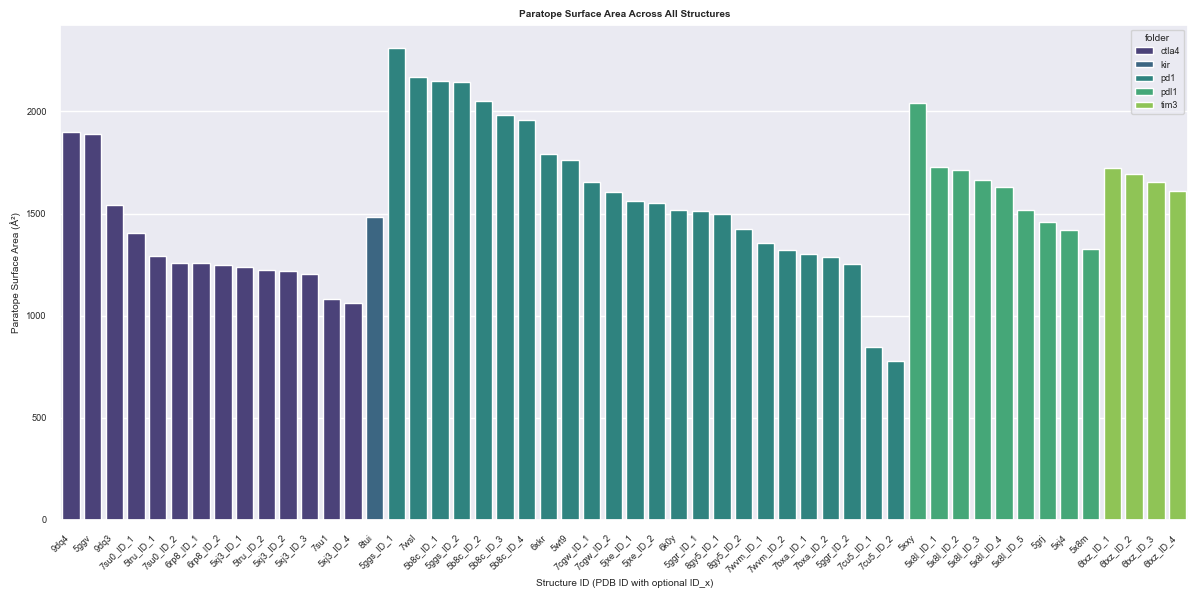

In [296]:

# Sort as before
df_sorted = df_struc_info.sort_values(by=["folder", "paratope_area"], ascending=[True, False]).copy()


# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="paratope_area", hue="folder", dodge=False, palette="viridis")


plt.title("Paratope Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Paratope Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/structural_analysis/paratopee_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



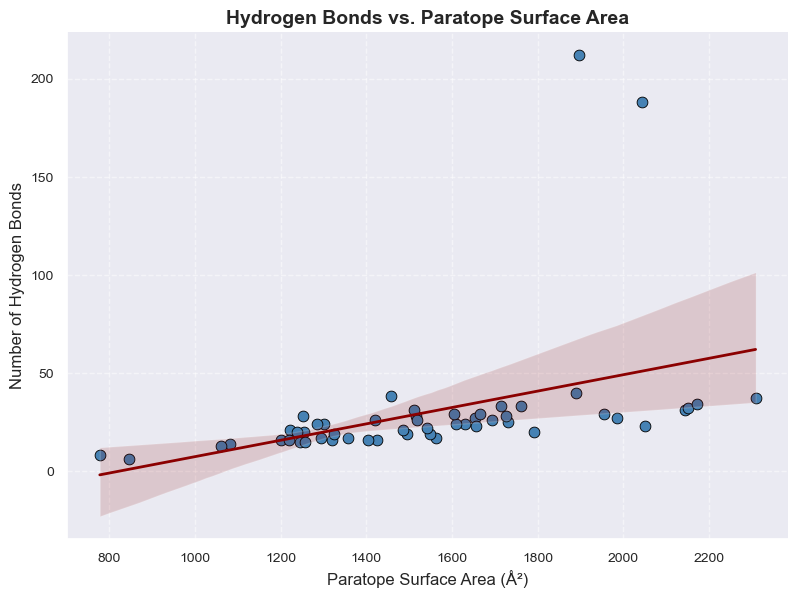

In [295]:
df_struc_info = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")

plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x="paratope_area",
    y="num_hydrogen_bonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x="paratope_area",
    y="num_hydrogen_bonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title("Hydrogen Bonds vs. Paratope Surface Area", fontsize=14, fontweight="bold")
plt.xlabel("Paratope Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig("plots/structural_analysis/hbonds_vs_surface_area.pdf", bbox_inches='tight')
plt.show()


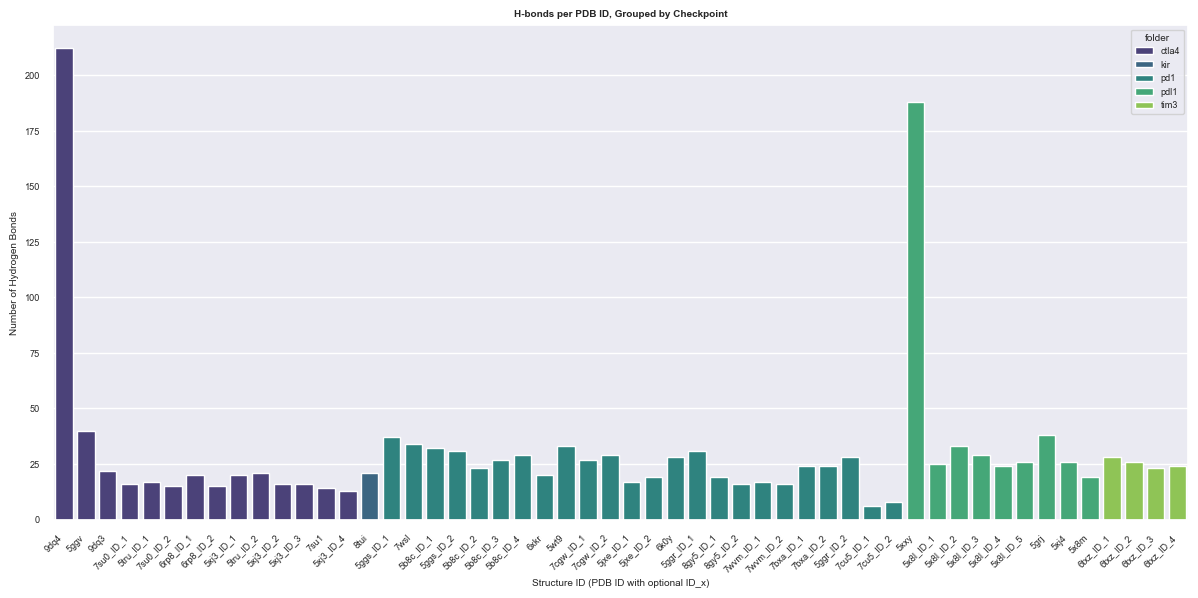

In [294]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title("H-bonds per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/structural_analysis/h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

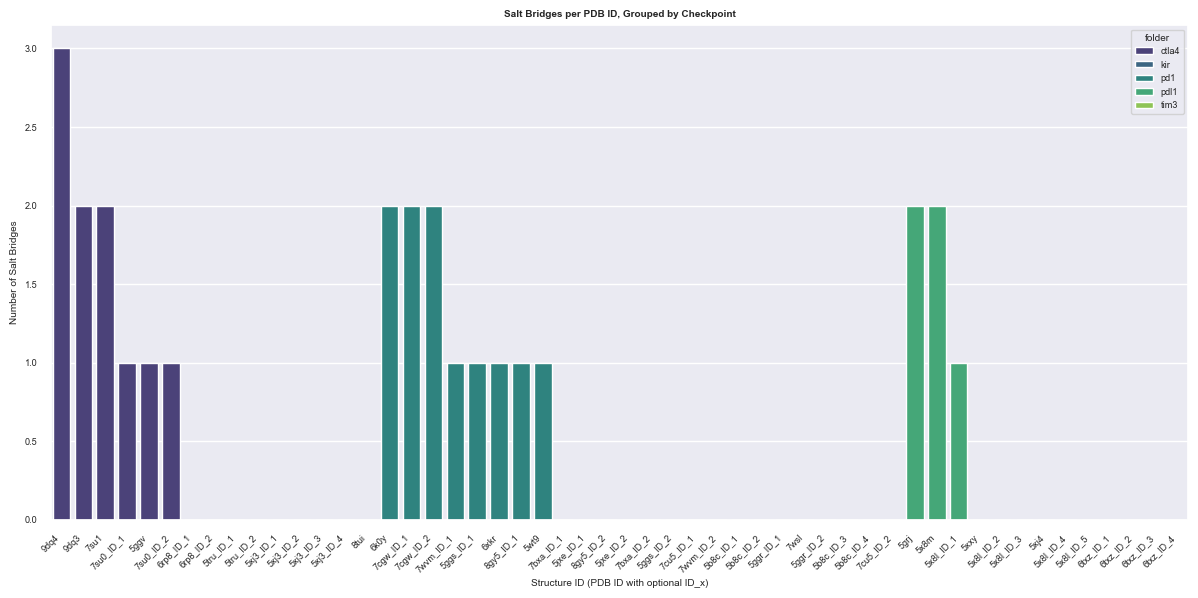

In [293]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title("Salt Bridges per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/structural_analysis/salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



# Binding Score 

In [262]:

#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", "paratope_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    "paratope_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm["paratope_area"] * weights["paratope_area"]
)

# Show top binders
print(df_norm.sort_values("binding_score", ascending=False)[["pdb_id", "binding_score"]])


   pdb_id  binding_score
26   9dq4       0.946239
9    5xxy       0.518688
23   7cgw       0.421995
34   7cgw       0.419402
5    5grj       0.417499
11   6k0y       0.405964
21   9dq3       0.397650
16   5x8m       0.363269
4    5ggs       0.360336
40   5ggv       0.344438
31   7su1       0.321967
33   5wt9       0.314146
15   6xkr       0.292989
0    5x8l       0.279508
17   5ggs       0.260194
30   8gy5       0.252315
42   7wsl       0.236411
35   7su0       0.234503
27   5b8c       0.229987
3    7wvm       0.223532
47   7su0       0.213487
45   5b8c       0.199163
32   5b8c       0.198566
49   5b8c       0.198451
14   5x8l       0.174748
24   6txz       0.166478
18   5x8l       0.161242
39   5x8l       0.160616
43   6txz       0.158448
36   6txz       0.147660
37   5ggr       0.144378
1    6txz       0.143712
38   5x8l       0.135432
12   5jxe       0.126071
7    5jxe       0.124032
22   5xj4       0.122888
50   8tui       0.121516
44   5ggr       0.104701
10   8gy5       0.103942


In [263]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", "paratope_area"],
    ascending=[False, False, False, False]  # show top-scoring binders first
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted_bs["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted_bs["structure_id"] = structure_ids

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/4289350764.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


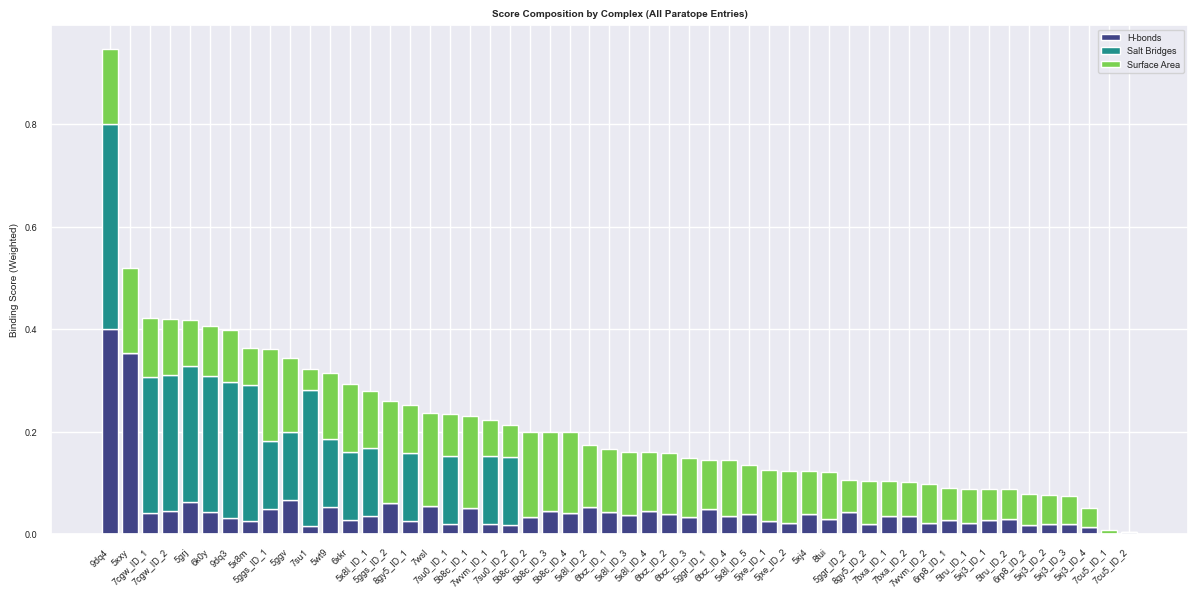

In [292]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top["paratope_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title("Score Composition by Complex (All Paratope Entries)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/structural_analysis/paratope_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




# Sequences Paratope

In [265]:
# not unqiue sequences
# Input settings
root_folder = "structures"
cutoff_distance = 5.0 
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

    # Extract unique residues from epitope
    model = cmd.get_model("paratope")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        "paratope_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id like in other analyses
df_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv("paratope_sequences_summary.csv", index=False)
print("Summary table saved to 'paratope_sequences_summary.csv'")

# Save FASTA
with open("paratope_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row['paratope_sequence']}\n")

print("FASTA file saved to 'paratope_sequences.fasta'")

# Add sequence to df_sorted

df_sorted_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
   


Processing 5x8l...
Processing 6txz...
Processing 6rp8...
Processing 7wvm...
Processing 5ggs...
Processing 5grj...
Processing 7bxa...
Processing 5jxe...
Processing 6rp8...
Processing 5xxy...
Processing 8gy5...
Processing 6k0y...
Processing 5jxe...
Processing 7bxa...
Processing 5x8l...
Processing 6xkr...
Processing 5x8m...
Processing 5ggs...
Processing 5x8l...
Processing 5tru...
Processing 7cu5...
Processing 9dq3...
Processing 5xj4...
Processing 7cgw...
Processing 6txz...
Processing 7wvm...
Processing 9dq4...
Processing 5b8c...
Processing 5tru...
Processing 5xj3...
Processing 8gy5...
Processing 7su1...
Processing 5b8c...
Processing 5wt9...
Processing 7cgw...
Processing 7su0...
Processing 6txz...
Processing 5ggr...
Processing 5x8l...
Processing 5x8l...
Processing 5ggv...
Processing 5xj3...
Processing 7wsl...
Processing 6txz...
Processing 5ggr...
Processing 5b8c...
Processing 5xj3...
Processing 7su0...
Processing 5xj3...
Processing 5b8c...
Processing 8tui...
Processing 7cu5...
Summary tabl

In [266]:
print(df_sorted_seq)

   pdb_id H_chain L_chain antigen_chain  \
40   5ggv       H       L             Y   
8    6rp8       h       l             c   
2    6rp8       H       L             C   
28   5tru       h       l             c   
29   5xj3       A       B             C   
48   5xj3       J       K             L   
41   5xj3       G       H             I   
46   5xj3       D       E             F   
19   5tru       H       L             C   
21   9dq3       H       L             C   
26   9dq4       H       L             A   
47   7su0       H       L             C   
35   7su0       I       M             D   
31   7su1       H       L             C   
50   8tui       H       L             A   
34   7cgw       H       L             P   
42   7wsl       H       L             D   
4    5ggs       C       D             Y   
17   5ggs       A       B             Z   
12   5jxe       G       F             A   
32   5b8c       K       J             L   
45   5b8c       H       G             I   
7    5jxe  

## Identiy Matrix

In [267]:
# Load sequences
records = list(SeqIO.parse("paratope_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv("paratope_sequence_comparison_matrix.csv")
print(" Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'")
print(df_identity)


 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
             5ggv  6rp8_ID_1  6rp8_ID_2  5tru_ID_1  5xj3_ID_1  5xj3_ID_2  \
5ggv       100.00      35.71      32.14      35.71      39.29      39.29   
6rp8_ID_1   35.71     100.00      95.00      90.91      90.48      81.82   
6rp8_ID_2   32.14      95.00     100.00      90.91      85.71      81.82   
5tru_ID_1   35.71      90.91      90.91     100.00      86.36      86.36   
5xj3_ID_1   39.29      90.48      85.71      86.36     100.00      90.91   
5xj3_ID_2   39.29      81.82      81.82      86.36      90.91     100.00   
5xj3_ID_3   32.14      85.00      85.00      77.27      85.71      81.82   
5xj3_ID_4   42.86      86.96      82.61      86.96      91.30      91.30   
5tru_ID_2   39.29      90.48      85.71      90.91      85.71      86.36   
9dq3        39.29      52.00      52.00      56.00      56.00      60.00   
9dq4        39.29      48.15      48.15      51.85      51.85      55.56   
7su0_ID_1  

In [268]:
# 1. Load sequences
records = list(SeqIO.parse("paratope_sequences.fasta", "fasta"))

# 2. Define PDB IDs to exclude (e.g. due to redundancy or outliers)
excluded_ids = {"7cu5_ID_2", "5x8l_ID_2", "6txz_ID_2", "6txz_ID_3"} 

# 3. Filter records
records = [rec for rec in records if rec.id not in excluded_ids]

# 4. Initialize identity matrix
matrix = []

# 5. Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100
        row.append(round(identity, 2))
    matrix.append(row)

# 6. Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# 7. Save and show
df_identity.to_csv("paratope_sequence_comparison_matrix.csv")
print("Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'")
print(df_identity)


Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
             5ggv  6rp8_ID_1  6rp8_ID_2  5tru_ID_1  5xj3_ID_1  5xj3_ID_2  \
5ggv       100.00      35.71      32.14      35.71      39.29      39.29   
6rp8_ID_1   35.71     100.00      95.00      90.91      90.48      81.82   
6rp8_ID_2   32.14      95.00     100.00      90.91      85.71      81.82   
5tru_ID_1   35.71      90.91      90.91     100.00      86.36      86.36   
5xj3_ID_1   39.29      90.48      85.71      86.36     100.00      90.91   
5xj3_ID_2   39.29      81.82      81.82      86.36      90.91     100.00   
5xj3_ID_3   32.14      85.00      85.00      77.27      85.71      81.82   
5xj3_ID_4   42.86      86.96      82.61      86.96      91.30      91.30   
5tru_ID_2   39.29      90.48      85.71      90.91      85.71      86.36   
9dq3        39.29      52.00      52.00      56.00      56.00      60.00   
9dq4        39.29      48.15      48.15      51.85      51.85      55.56   
7su0_ID_1   

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/3853486739.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{x:.0f}")


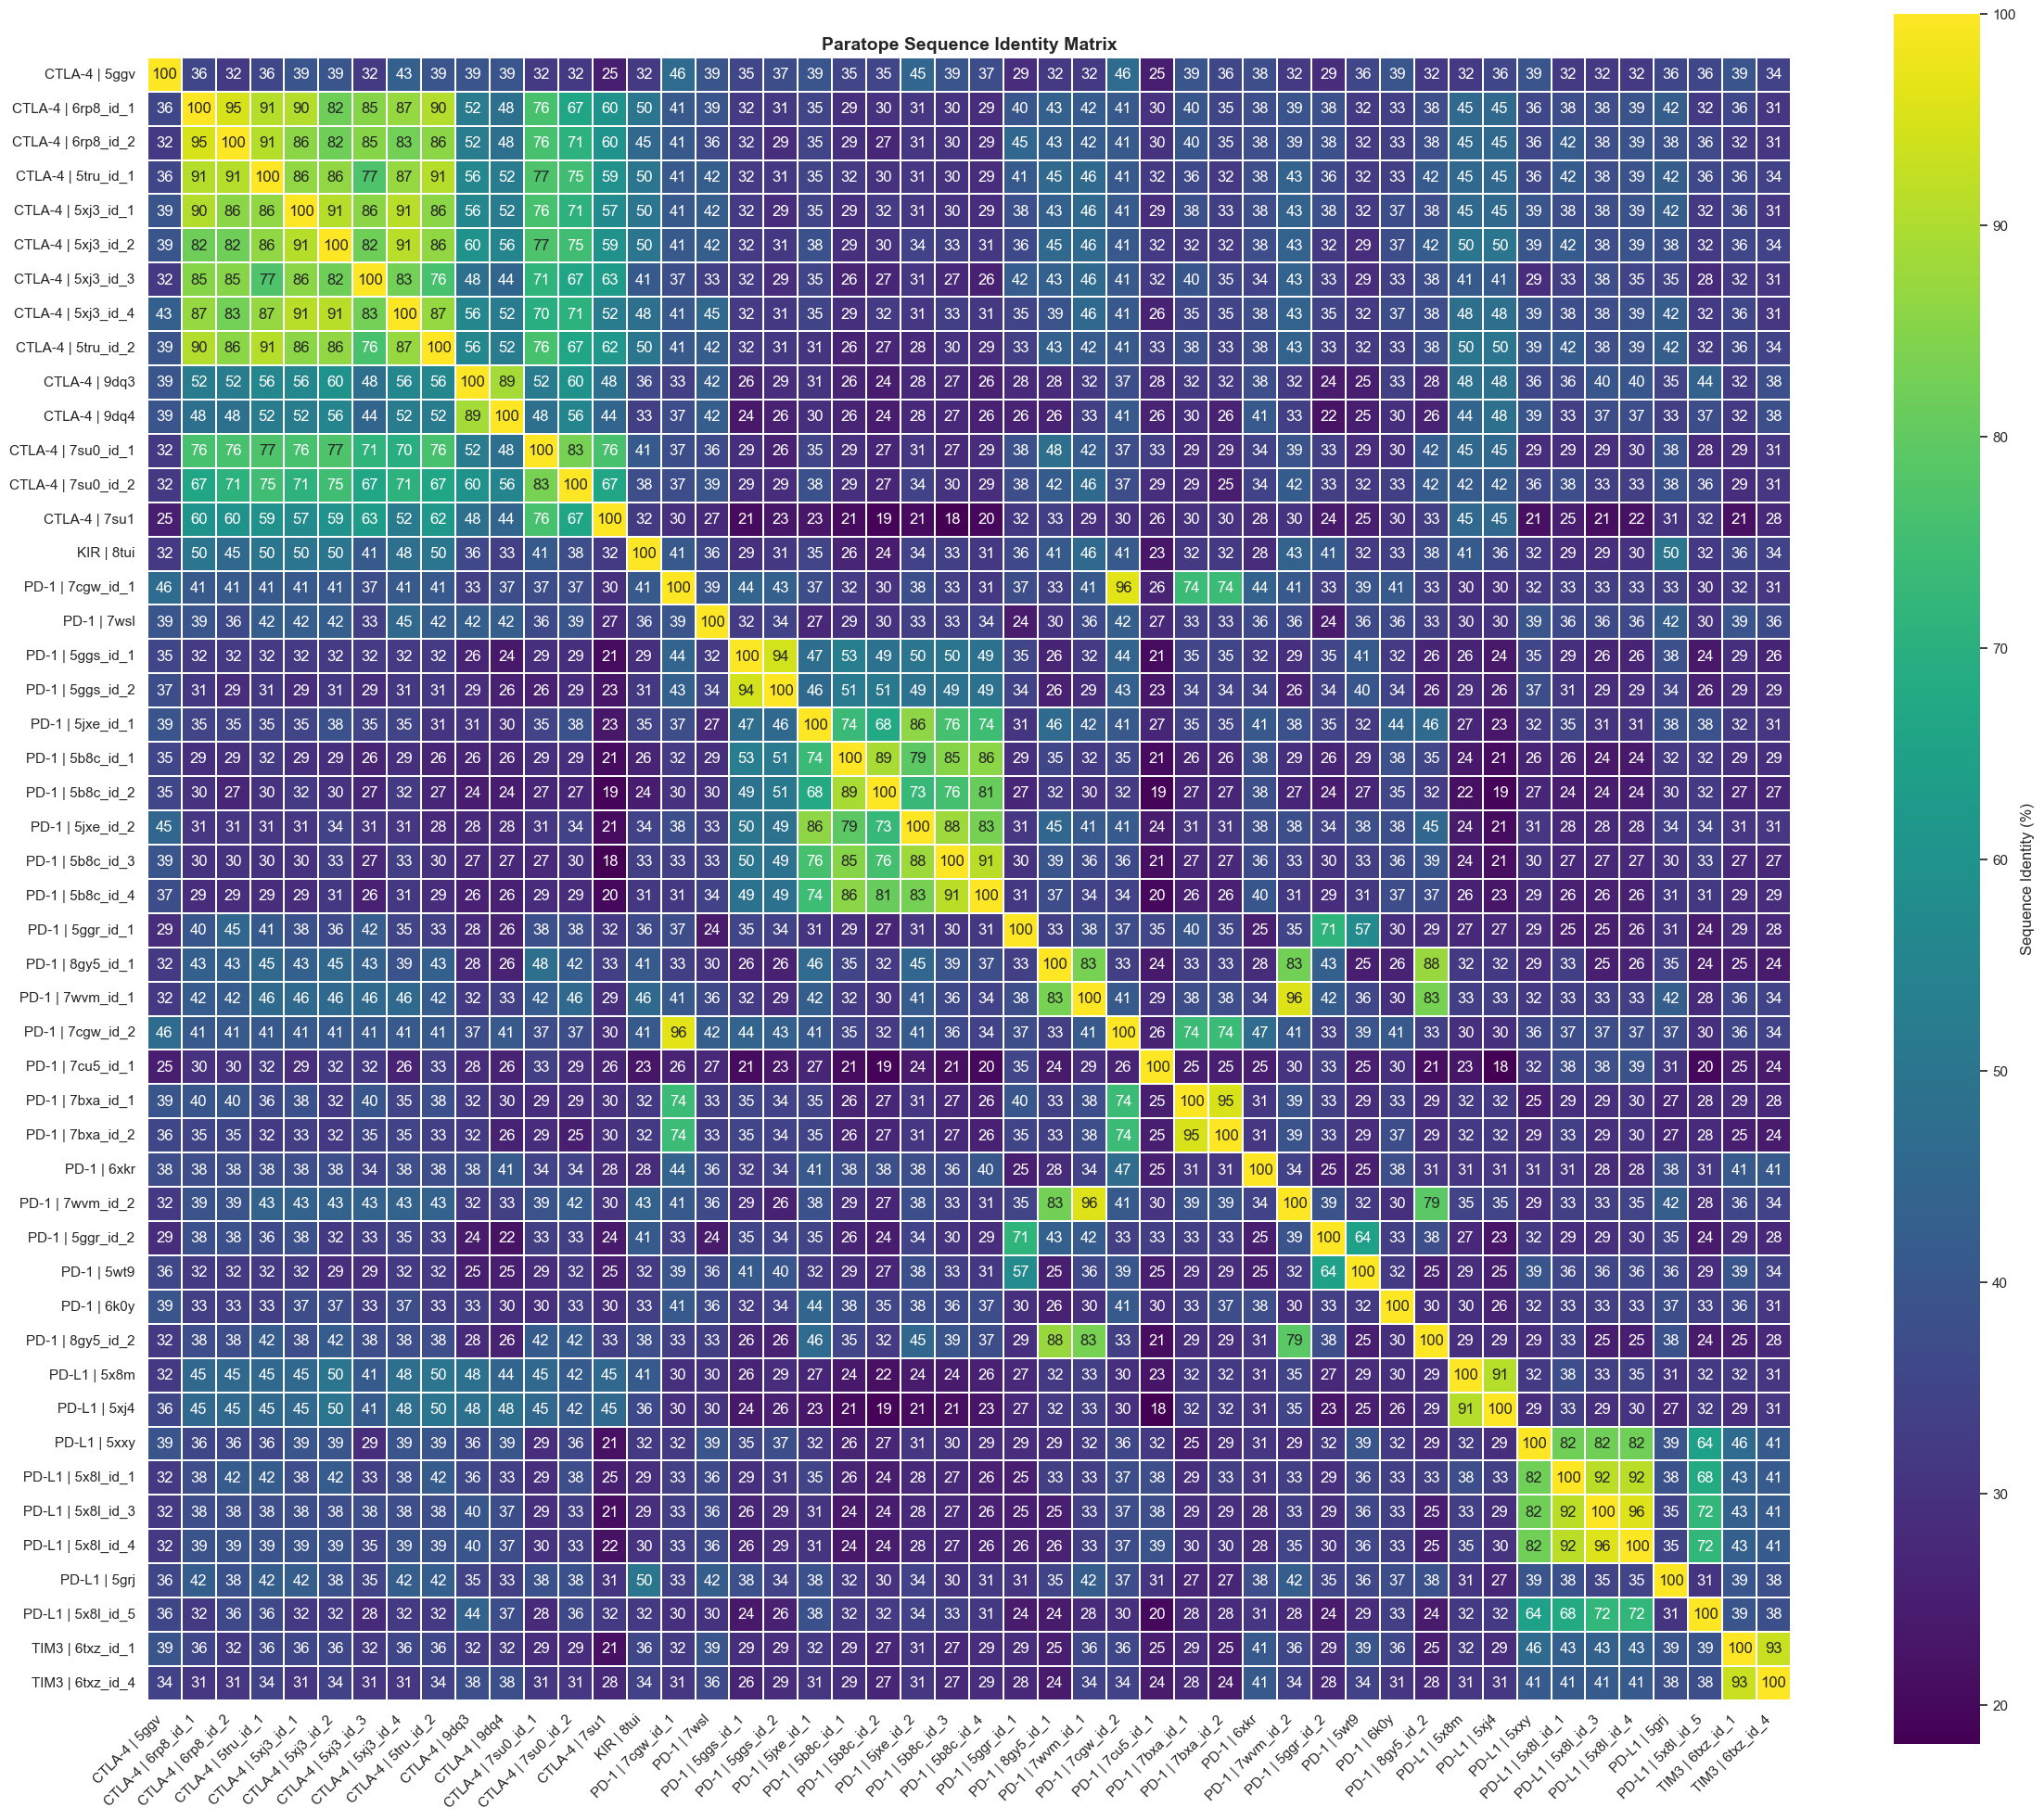

Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.pdf'


In [288]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''welche werte,...'''

    base_id = pdb_id.lower().split('_')[0]  # e.g. "5x8l_ID_1" → "5x8l"
    checkpoint = pdb_to_checkpoint[base_id]
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]



annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)

ax = sns.heatmap(
    df_identity, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Paratope Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig("plots/structural_analysis/paratope_identity_heatmap_final.pdf", dpi=300)
plt.show()

print("Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.pdf'")

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/3020052759.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


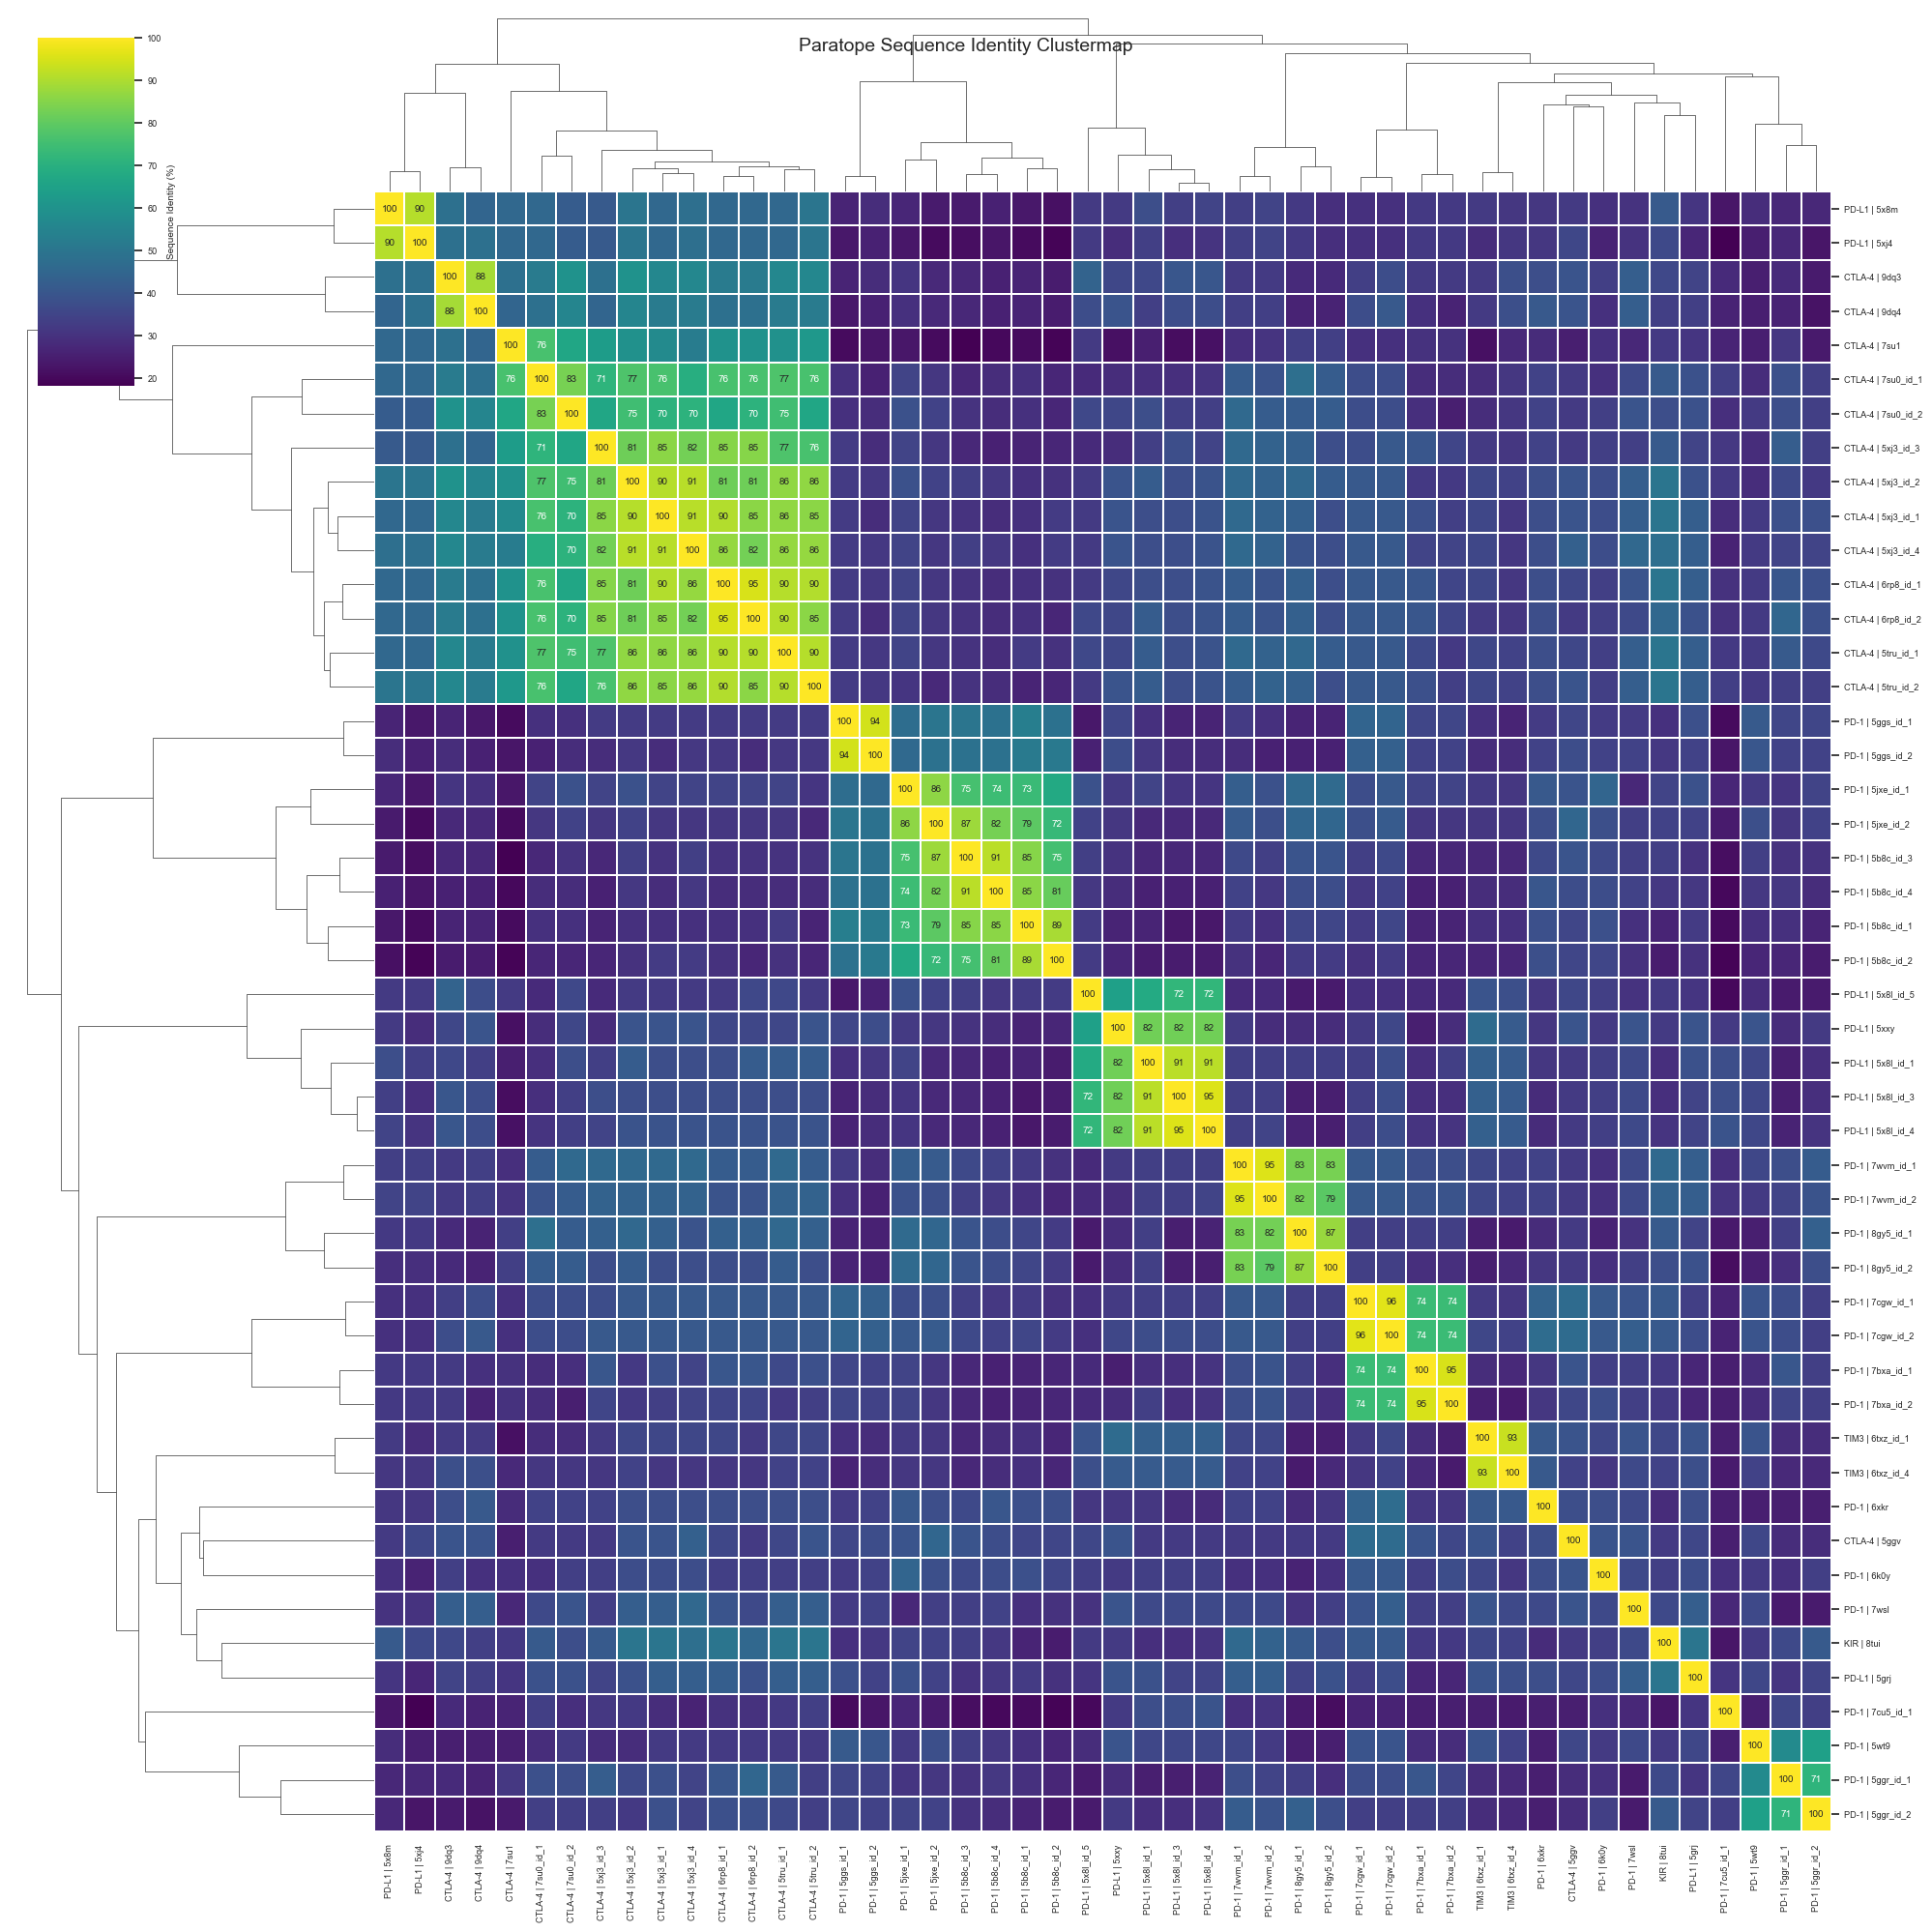

In [289]:
# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# clustermap
sns.set(font_scale=0.6)  # smaller font for big matrices
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)

#save 
g.fig.suptitle("Paratope Sequence Identity Clustermap", fontsize=14)
plt.savefig("plots/structural_analysis/paratope_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


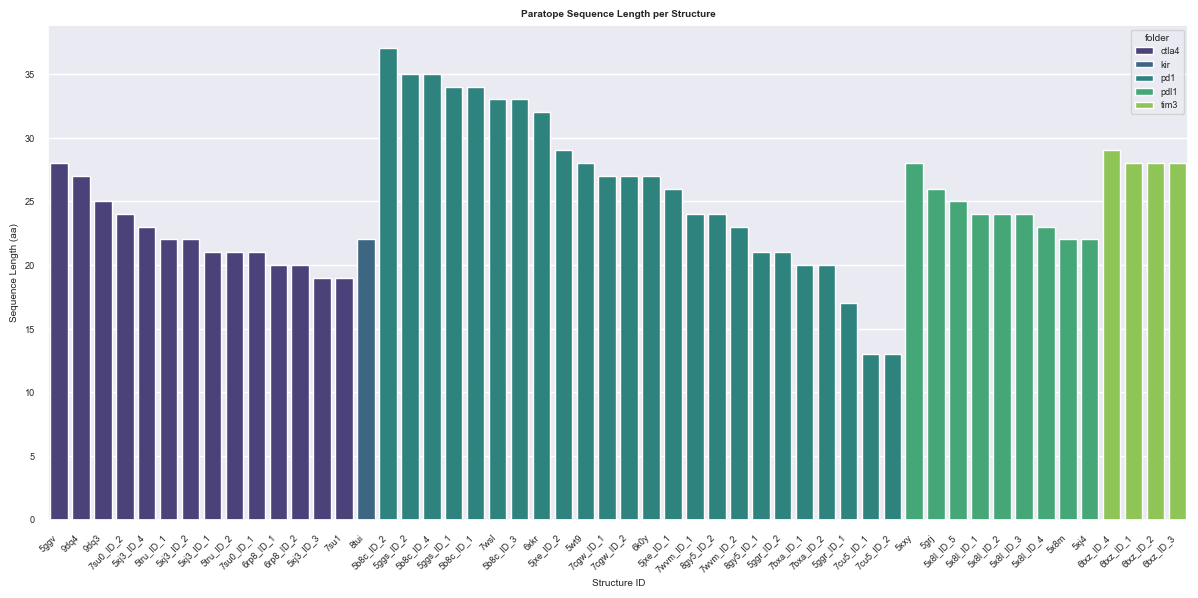

In [290]:
# Add column with sequence length
df_seq["paratope_length"] = df_seq["paratope_sequence"].str.len()

# Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", "paratope_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y="paratope_length", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("plots/structural_analysis/paratope_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


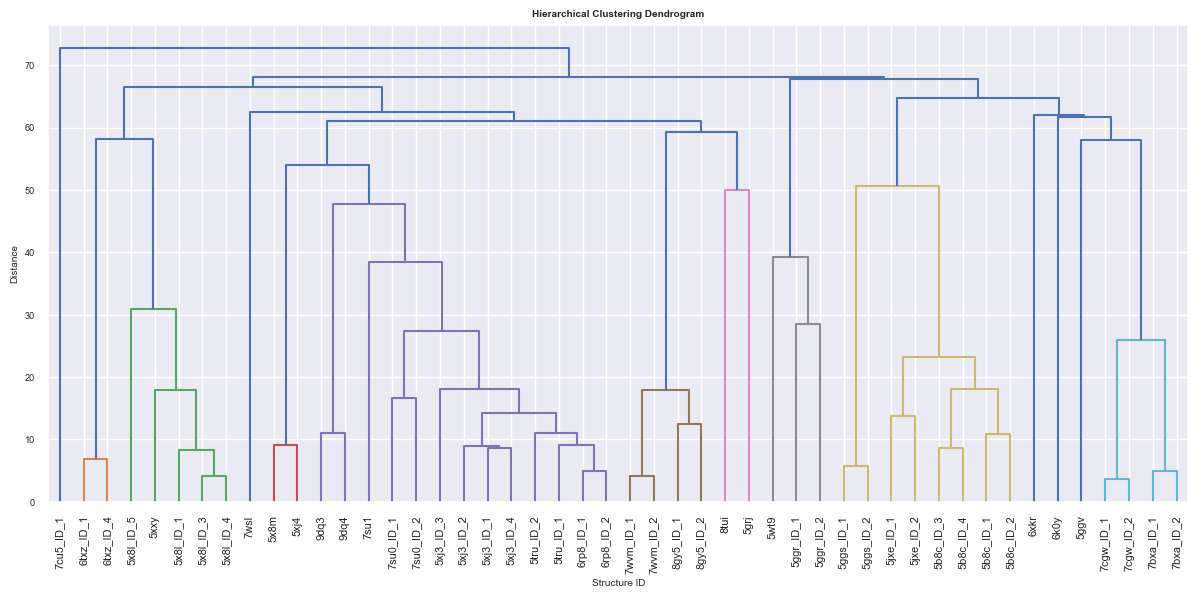

Cluster labels saved to 'cluster_labels.csv'


In [272]:
# === Step 1: Load the distance matrix ===
# Replace with your actual distance matrix CSV
df_distance = pd.read_csv("paratope_sequence_comparison_matrix.csv", index_col=0)

# === Step 2: Convert similarity to distance if needed ===
# If your matrix contains similarity (e.g. % identity), convert it:
df_dist = 100 - df_distance  # assuming 100% is max similarity

# === Step 3: Condense the distance matrix ===
# Hierarchical clustering needs a condensed distance matrix (lower triangle)
condensed_dist = df_dist.values[np.triu_indices_from(df_dist, k=1)]

# === Step 4: Perform hierarchical clustering ===
Z = linkage(condensed_dist, method='average')  # or 'ward', 'single', etc.

# === Step 5: Assign clusters ===
# Adjust t or n_clusters as needed
n_clusters = 6
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# === Step 6: Create a labeled DataFrame ===
df_labels = pd.DataFrame({
    'structure_id': df_dist.index,
    'cluster': clusters
})

# === Step 7: Plot dendrogram ===
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_dist.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Structure ID")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# === Step 8: Save results ===
df_labels.to_csv("cluster_labels.csv", index=False)
print("Cluster labels saved to 'cluster_labels.csv'")


In [273]:
import pandas as pd
from collections import defaultdict, Counter

# 1. Load data
df_struct = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")

# 2. Create structure_id in df_struct
id_frequencies = Counter(df_struct["pdb_id"])
id_tracker = defaultdict(int)
structure_ids = []
for pdb_id in df_struct["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}ID{id_tracker[pdb_id]}")
df_struct["structure_id"] = structure_ids

# 3. Optional: remove duplicates from df_norm if needed
df_norm = df_norm.drop_duplicates(subset="pdb_id")

# 4. Merge everything
all_df = pd.merge(df_struct, df_sorted_seq[["structure_id", "paratope_sequence"]], on="structure_id", how="left")
all_df = pd.merge(all_df, df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

# 5. Save
all_df.to_csv("structural_paratope_all_information_final.csv", index=False)

In [274]:
# import pandas as pd
# from collections import defaultdict, Counter

# # 1. Load data
# df_struct = pd.read_csv("paratope_surface_hbonds_salt_bridges_summary.csv")

# # 2. Create structure_id in df_struct
# id_frequencies = Counter(df_struct["pdb_id"])
# id_tracker = defaultdict(int)
# structure_ids = []

# for pdb_id in df_struct["pdb_id"]:
#     if id_frequencies[pdb_id] == 1:
#         structure_ids.append(pdb_id)
#     else:
#         id_tracker[pdb_id] += 1
#         structure_ids.append(f"{pdb_id}ID{id_tracker[pdb_id]}")

# df_struct["structure_id"] = structure_ids

# # 3. Create same structure_id column in df_sorted_seq
# id_frequencies_seq = Counter(df_sorted_seq["pdb_id"])
# id_tracker_seq = defaultdict(int)
# structure_ids_seq = []

# for pdb_id in df_sorted_seq["pdb_id"]:
#     if id_frequencies_seq[pdb_id] == 1:
#         structure_ids_seq.append(pdb_id)
#     else:
#         id_tracker_seq[pdb_id] += 1
#         structure_ids_seq.append(f"{pdb_id}ID{id_tracker_seq[pdb_id]}")

# df_sorted_seq["structure_id"] = structure_ids_seq

# # 4. Merge everything
# all_df = pd.merge(
#     df_struct,
#     df_sorted_seq[["structure_id", "paratope_sequence"]],
#     on="structure_id",
#     how="left"
# )

# all_df = pd.merge(
#     all_df,
#     df_norm[["pdb_id", "binding_score"]],
#     on="pdb_id",
#     how="left"
# )

# # 5. Optional: Rename 'folder' column to 'checkpoint' if relevant
# all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

# # 6. Save result
# all_df.to_csv("structural_paratope_all_information_final.csv", index=False)

# # 7. Check result
# print(all_df.head())


In [275]:
all_df.rename(columns={"folder": "checkpoint"}, inplace=True)
print(all_df)

   pdb_id H_chain L_chain antigen_chain  paratope_area  num_hydrogen_bonds  \
0    5x8l       S       N             D    1629.124878                  24   
1    6txz       I       M             B    1610.267578                  24   
2    6rp8       H       L             C    1255.458130                  20   
3    7wvm       A       B             E    1319.529053                  16   
4    5ggs       C       D             Y    2143.817871                  31   
5    5grj       H       L             A    1456.677368                  38   
6    7bxa       H       L             P    1300.951294                  24   
7    5jxe       D       C             B    1563.665527                  17   
8    6rp8       h       l             c    1245.991455                  15   
9    5xxy       H       L             A    2043.012085                 188   
10   8gy5       A       B             Q    1424.736572                  16   
11   6k0y       A       B             C    1517.019287          

# Do cluster have different binding affinities? 

In [276]:
# Bindungsstärke zwischne den Clustern

manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
}

# df -> Bindungsstärke

import pandas as pd


# 1. Manuelles Cluster-Dict in Liste umwandeln
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# 2. DataFrame daraus
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge mit Haupt-DataFrame (z. B. mit binding_score)
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

# Ergebnis anschauen
print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    5x8m  Cluster 1       0.363269       pdl1
1    5xj4  Cluster 1       0.122888       pdl1
2    9dq3  Cluster 1       0.397650      ctla4
3    9dq4  Cluster 1       0.946239      ctla4
4    7su1  Cluster 1       0.321967      ctla4
5    7su0  Cluster 1       0.234503      ctla4
6    7su0  Cluster 1       0.234503      ctla4
7    5xj3  Cluster 1       0.074734      ctla4
8    5xj3  Cluster 1       0.074734      ctla4
9    5xj3  Cluster 1       0.074734      ctla4
10   5xj3  Cluster 1       0.074734      ctla4
11   6rp8  Cluster 1       0.089596      ctla4
12   6rp8  Cluster 1       0.089596      ctla4
13   5tru  Cluster 1       0.087214      ctla4
14   5tru  Cluster 1       0.087214      ctla4
15   6txz  Cluster 2       0.143712       tim3
16   6txz  Cluster 2       0.143712       tim3
17   6txz  Cluster 2       0.143712       tim3
18   6txz  Cluster 2       0.143712       tim3
19   5xB1  Cluster 3            NaN        NaN
20   5xxy  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/1868314087.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


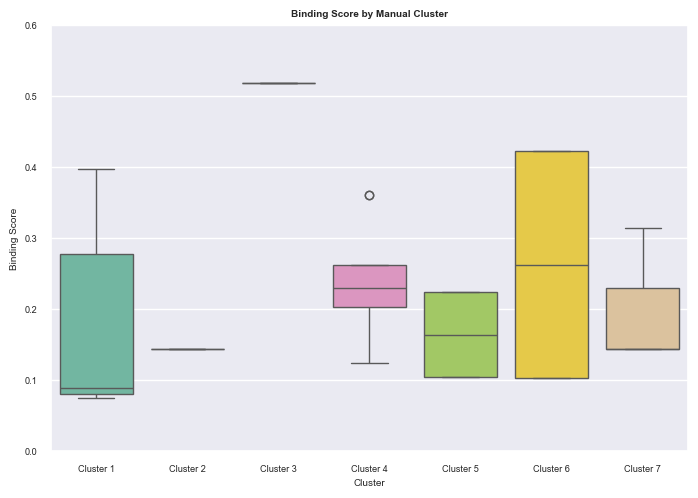

In [291]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title("Binding Score by Manual Cluster")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig("plots/structural_analysis/paratope_binding_score_by_cluster.pdf", bbox_inches='tight')


In [278]:
from scipy.stats import kruskal

# 1. Daten nach Cluster gruppieren
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# 2. Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 6.372, p = 3.8284e-01


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


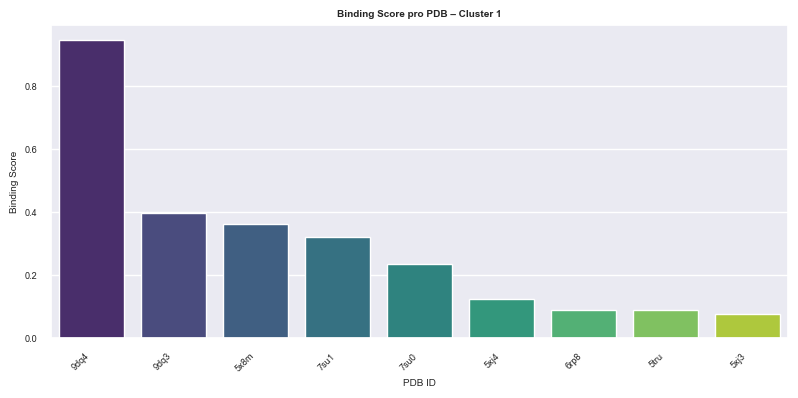

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


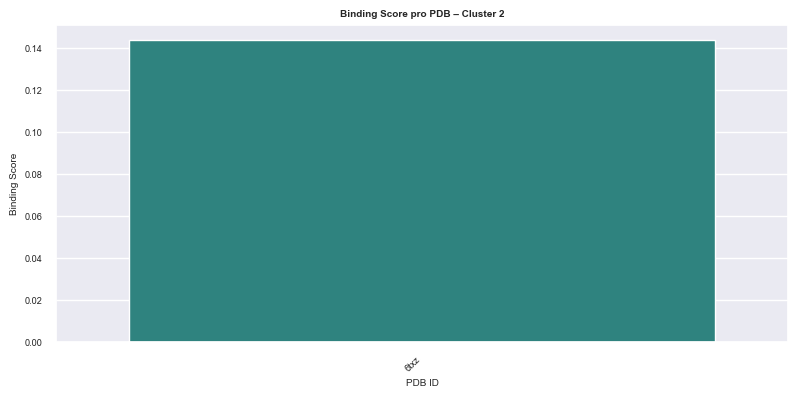

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


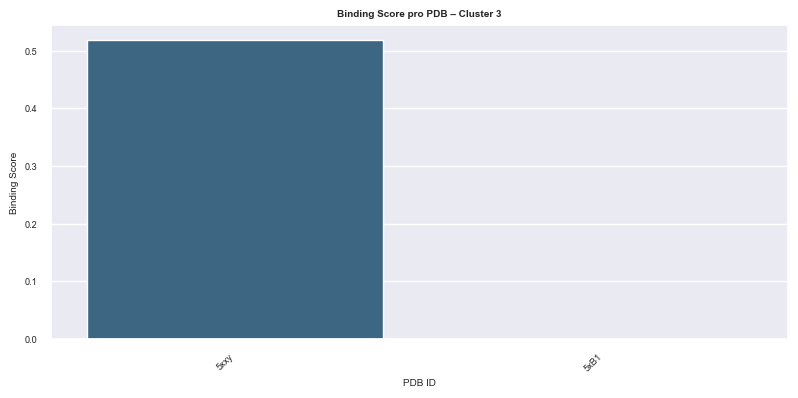

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


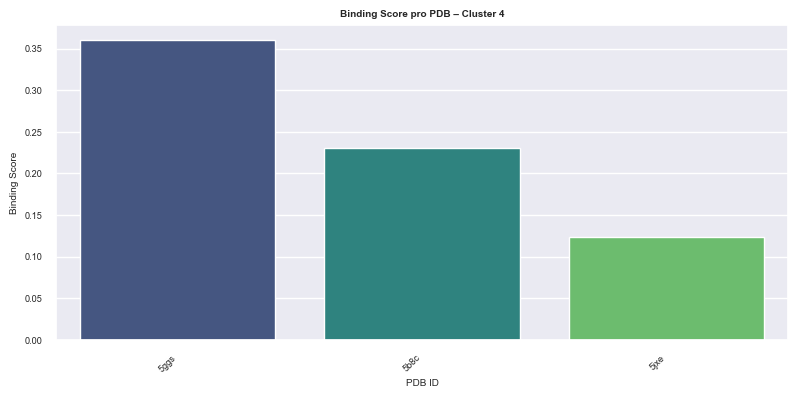

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


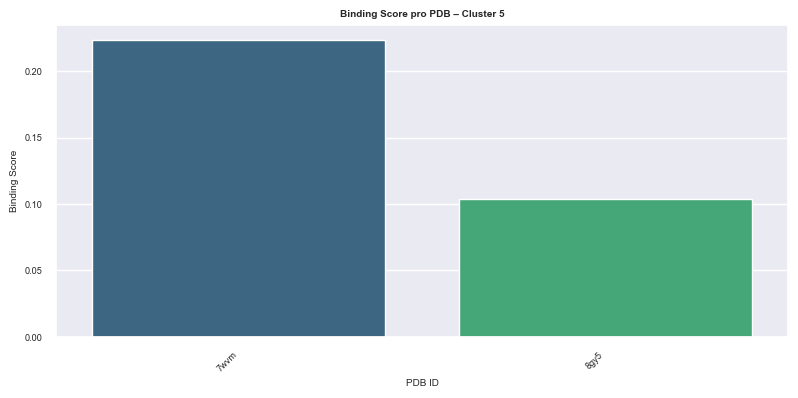

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


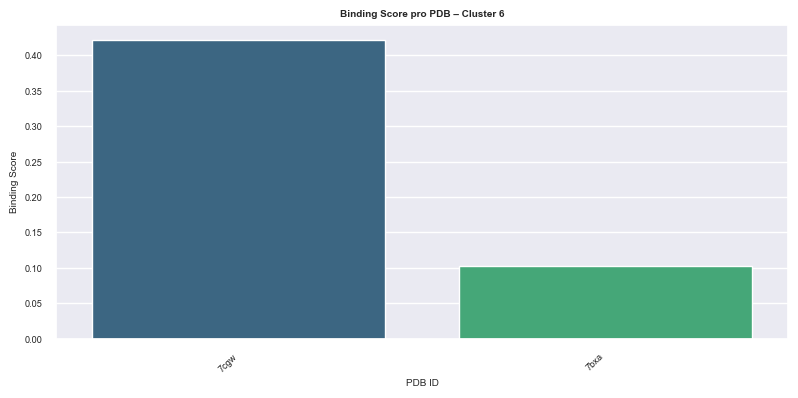

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


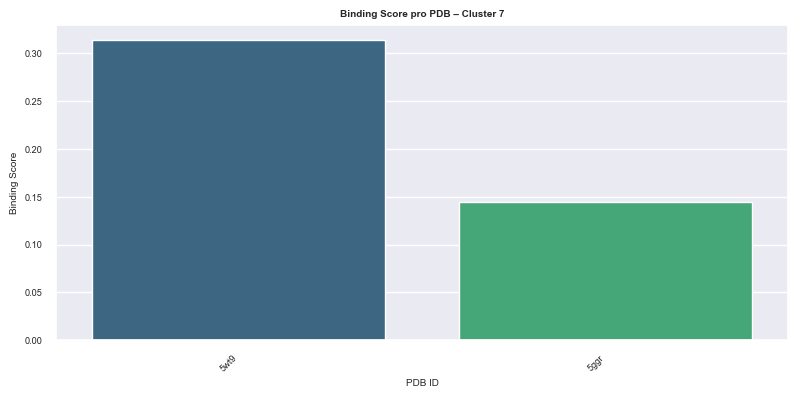

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterliste ermitteln
clusters = merged_df["cluster"].unique()

# Plot pro Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2607721816.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])


Mann–Whitney U-Statistik: 64001.00
P-Wert: 0.2709


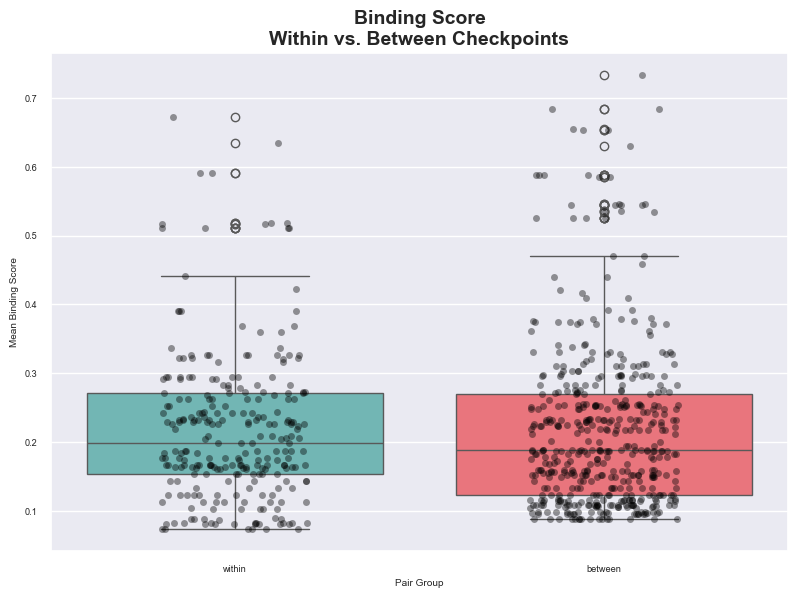

In [280]:
from itertools import combinations
from scipy.stats import mannwhitneyu

# Step 1: Drop NaNs in binding_score or checkpoint before pairing
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Step 2: Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"]
        })

# Step 3: Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Step 4: Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Step 5: Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title("Binding Score\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [281]:
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

                    ctla-4 | 5ggv  ctla-4 | 6rp8_id_1  ctla-4 | 6rp8_id_2  \
ctla-4 | 5ggv              100.00               35.71               32.14   
ctla-4 | 6rp8_id_1          35.71              100.00               95.00   
ctla-4 | 6rp8_id_2          32.14               95.00              100.00   
ctla-4 | 5tru_id_1          35.71               90.91               90.91   
ctla-4 | 5xj3_id_1          39.29               90.48               85.71   
ctla-4 | 5xj3_id_2          39.29               81.82               81.82   
ctla-4 | 5xj3_id_3          32.14               85.00               85.00   
ctla-4 | 5xj3_id_4          42.86               86.96               82.61   
ctla-4 | 5tru_id_2          39.29               90.48               85.71   
ctla-4 | 9dq3               39.29               52.00               52.00   
ctla-4 | 9dq4               39.29               48.15               48.15   
ctla-4 | 7su0_id_1          32.14               76.19               76.19   

In [282]:
from itertools import combinations
import pandas as pd

pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)
print(df_pairs.head())


   pdb1  pdb2  identity  same_checkpoint
0  9dq3  9dq4     88.89             True
1  9dq3  7su1     48.00             True
2  9dq3  5wt9     25.00            False
3  9dq3  5x8m     48.00            False
4  9dq3  5xj4     48.00            False


In [283]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


Mann–Whitney U-Statistik: 64.00
P-Wert: 0.0737


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/1129673701.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])


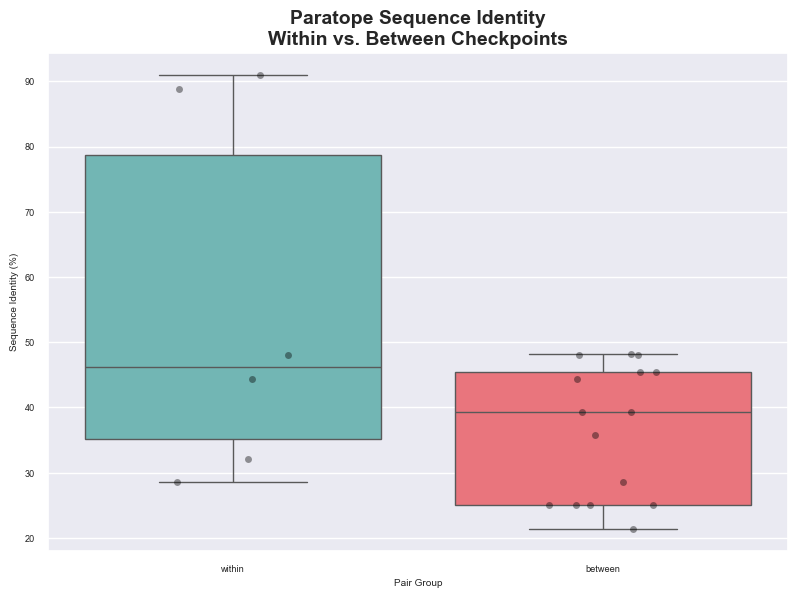

In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Optional: Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title("Paratope Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [285]:
all_df

,pdb_id,H_chain,L_chain,antigen_chain,paratope_area,num_hydrogen_bonds,num_salt_bridges,checkpoint,structure_id,paratope_sequence,binding_score
0,5x8l,S,N,D,1629.124878,24,1,pdl1,5x8lID1,NaN,0.279508
1,6txz,I,M,B,1610.267578,24,0,tim3,6txzID1,NaN,0.143712
2,6rp8,H,L,C,1255.458130,20,0,ctla4,6rp8ID1,NaN,0.089596
3,7wvm,A,B,E,1319.529053,16,1,pd1,7wvmID1,NaN,0.223532
4,5ggs,C,D,Y,2143.817871,31,1,pd1,5ggsID1,NaN,0.360336
5,5grj,H,L,A,1456.677368,38,2,pdl1,5grj,FTSSIYPSGGIFLGTVTTYYDYSSSR,0.417499
6,7bxa,H,L,P,1300.951294,24,0,pd1,7bxaID1,NaN,0.103305
7,5jxe,D,C,B,1563.665527,17,0,pd1,5jxeID1,NaN,0.124032
8,6rp8,h,l,c,1245.991455,15,0,ctla4,6rp8ID2,NaN,0.089596
9,5xxy,H,L,A,2043.012085,188,0,pdl1,5xxy,TSDSWWSPYGGSTYTRHWPGSAYYLYHP,0.518688


In [286]:
import pandas as pd

wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_best_df)

filtered_best_df.to_csv('filtered_pdbs.csv', index=False)





   pdb_id H_chain L_chain antigen_chain  paratope_area  num_hydrogen_bonds  \
0    5x8l       S       N             D    1629.124878                  24   
4    5ggs       C       D             Y    2143.817871                  31   
6    7bxa       H       L             P    1300.951294                  24   
7    5jxe       D       C             B    1563.665527                  17   
9    5xxy       H       L             A    2043.012085                 188   
12   5jxe       G       F             A    1549.543579                  19   
13   7bxa       B       C             A    1285.269775                  24   
14   5x8l       H       M             C    1714.077026                  33   
16   5x8m       B       C             A    1323.962769                  19   
17   5ggs       A       B             Z    2308.719238                  37   
18   5x8l       F       K             A    1729.596069                  25   
22   5xj4       H       L             A    1421.128174          

In [287]:

import pandas as pd

wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_worst_df)

filtered_worst_df.to_csv('filtered_pdbs.csv', index=False)

   pdb_id H_chain L_chain antigen_chain  paratope_area  num_hydrogen_bonds  \
0    5x8l       S       N             D    1629.124878                  24   
4    5ggs       C       D             Y    2143.817871                  31   
6    7bxa       H       L             P    1300.951294                  24   
7    5jxe       D       C             B    1563.665527                  17   
9    5xxy       H       L             A    2043.012085                 188   
12   5jxe       G       F             A    1549.543579                  19   
13   7bxa       B       C             A    1285.269775                  24   
14   5x8l       H       M             C    1714.077026                  33   
16   5x8m       B       C             A    1323.962769                  19   
17   5ggs       A       B             Z    2308.719238                  37   
18   5x8l       F       K             A    1729.596069                  25   
22   5xj4       H       L             A    1421.128174          